In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from circuit_breaker.cb import cb
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from time import time

# Performance Metrics

In [5]:
def rmse(yobs, yhat):
    return np.sqrt(np.mean((yobs-yhat) ** 2.0))

def sharpe(ret_obs, signal, benchmark=0):
    strat_return = ret_obs*signal - benchmark
    return np.mean(strat_return)/np.std(strat_return) * np.sqrt(252)

# Utils

In [6]:
def ts_df(ts, lags):
    df = pd.DataFrame(index=ts.index, columns=["lag_" + str(x) for x in range(lags+1)])
    for i in range(lags+1):
        df["lag_" + str(i)] = ts.shift(i)

    return df.dropna()

# Initial Setup

In [8]:
def plot_perf(results, method, axs=[False]):
    if not np.any(axs):
        fig, axs = plt.subplots(1, 2, figsize=(15,4))        
        axs[0].set_title('Error')
        axs[0].set_xlabel('Time')
        axs[1].set_title('Sharpe')
        axs[1].set_xlabel('Time')
        
    error = list(map(rmse, results['Obs'].values, results['Pred'].values))
    axs[0].bar(pd.to_datetime(results.index), error, label=method)
    axs[0].legend()
    
    axs[1].bar(pd.to_datetime(results.index), results['Sharpe'], label=method)
    axs[1].legend()
    
    if np.any(axs):
        plt.show()
    
    return axs

In [9]:
def train_strat(trad_strat, data, warmup, test_size=1):
    train_data = data[:warmup]
    test_data = data[warmup:]
    results = pd.DataFrame(index=test_data.index, columns=["Step", "Obs", "Pred"]\
                           + perf_metrics_labels)
    k = 0

    while test_data.shape[0] != 0:
        # index test
        test_index = test_data.index[:test_size]

        # train model
        trad_strat.fit(train_data.drop(labels=output_label, axis=1),\
                       train_data[[output_label]])
        train_obs = train_data[output_label].values
        train_pred = trad_strat.predict(train_data.drop(labels=output_label, axis=1))

        # train metrics
        for (pf, pf_label) in zip(perf_metrics_funcs, perf_metrics_labels):
            results.loc[test_index, pf_label] = pf(train_obs, train_pred)

        # test model
        test_pred = trad_strat.predict(test_data.iloc[:test_size].\
                                       drop(labels=output_label, axis=1)) 
        results.loc[test_index, "Pred"] = test_pred
        test_obs = test_data.iloc[:test_size][output_label]
        results.loc[test_index, "Obs"] = test_obs.values

        # update data
        results.loc[k, "Step"] = k
        train_data = pd.concat([train_data, test_data.iloc[:test_size].copy()])
        train_data = train_data.iloc[stride_size:].copy()
        test_data = test_data.iloc[test_size:].copy()
        k += 1

        print(k, test_data.shape[0])
    
    return results

In [10]:
def train_detection(data, method, cb = trading_cb, bootstrap_n = 500, k = 3):
    methods = {
        'dbscan': {
            'tune': cb.tune_dbscan,
            'train': cb.train_dbscan,
            'test': cb.test_dbscan
        },
        'knn': {
            'tune': cb.tune_knn,
            'train': cb.train_knn,
            'test': cb.test_knn
        }
    }
    norm_data = pd.DataFrame()
    abnorm_data = pd.DataFrame()

    cb.reset()
    data = data.drop('Step', axis = 1, errors='ignore').dropna()
    bootstrap = data.iloc[:bootstrap_n]
    norm_i, abnorm_i = methods[method]['tune'](bootstrap.\
                        drop(labels=output_label, axis=1, errors='ignore'))
    train_data = bootstrap.iloc[sorted(norm_i)]
    norm_data = norm_data.append(train_data)
    abnorm_data = abnorm_data.append(bootstrap.iloc[abnorm_i])
    methods[method]['train'](train_data.\
                             drop(labels=output_label, axis=1, errors='ignore'))

    for i in range(bootstrap_n, data.shape[0]):
        if method == 'dbscan':
            methods[method]['test'](train_data.\
            drop(labels=output_label, axis=1, errors='ignore'),\
            data.iloc[i].drop(labels=output_label, errors='ignore'))
        else:
            methods[method]['test'](data.iloc[i].\
            drop(labels=output_label, errors='ignore'))

        if cb.alert:
            abnorm_data = abnorm_data.append(data.iloc[i])
            cb.reset()
        else:
            train_data = train_data.append(data.iloc[i])
            if method != 'dbscan':
                methods[method]['train'](train_data.\
                drop(labels=output_label, axis=1, errors='ignore'))
            norm_data = norm_data.append(data.iloc[i])

        print(i, data.shape[0] - i)
    
    return norm_data, abnorm_data

In [60]:
def train_nn_detection(data, cb = trading_cb, bootstrap_n = 1260):
    norm_data = pd.DataFrame()
    abnorm_data = pd.DataFrame()

    cb.reset()
    data = data.drop('Step', axis = 1, errors='ignore').dropna()
    bootstrap = data.iloc[:bootstrap_n]
    warmup_preds = cb.tune_nn(bootstrap.\
                    drop(labels=[output_label, 'abnorm'], axis=1, errors='ignore'), \
                    bootstrap['abnorm'])
    for i in range(len(bootstrap)):
        if warmup_preds[i]:
            abnorm_data = abnorm_data.append(bootstrap.iloc[i])
        else:
            norm_data = norm_data.append(bootstrap.iloc[i])

    cb.train_nn(bootstrap.\
                drop(labels=[output_label, 'abnorm'], axis=1, errors='ignore'), \
                bootstrap['abnorm'])

    for i in range(bootstrap_n, len(data)):
        cb.test_nn(data.iloc[i].\
                   drop(labels=[output_label, 'abnorm'], errors='ignore'))
        cb.train_nn(data.iloc[:i].\
                    drop(labels=[output_label, 'abnorm'], axis=1, errors='ignore'), \
                    data['abnorm'].iloc[:i])

        if cb.alert:
            abnorm_data = abnorm_data.append(data.iloc[i])
            cb.reset()
        else:
            norm_data = norm_data.append(data.iloc[i])

        print(i, data.shape[0] - i)
    
    return norm_data.drop(labels='abnorm', axis=1, errors='ignore'),\
            abnorm_data.drop(labels='abnorm', axis=1, errors='ignore')

In [53]:
def label_data(norm, abnorm):
    norm = norm.copy()
    abnorm = abnorm.copy()
    norm['abnorm'] = 0
    abnorm['abnorm'] = 1
    return pd.concat([norm, abnorm]).sort_index()

In [11]:
def print_ratio(method, norm, abnorm):
    print('%s \nNormal: %d, Abnormal: %d, Ratio: %3f' % \
          (method, len(norm), len(abnorm), len(abnorm) / len(norm + abnorm)))

In [108]:
def print_stats(metric, method_1, method_2, data_1, data_2):
    if not data_1.empty:
        rmse_1 = rmse(data_1['Obs'], data_1['Pred'])
        sharpe_1 = sharpe(data_1['Obs'], data_1['Pred'])
    else:
        rmse_1 = 'N/A'
        sharpe_1 = 'N/A'
        
    if not data_2.empty:
        rmse_2 = rmse(data_2['Obs'], data_2['Pred'])
        sharpe_2 = sharpe(data_2['Obs'], data_2['Pred'])
    else:
        rmse_2 = 'N/A'
        sharpe_2 = 'N/A'
    
    print('{}\t\t{}\t\t{}'.format(metric, method_1, method_2))
    print('RMSE\t\t{}\t{}'.format(rmse_1, rmse_2))
    print('Sharpe\t\t{}\t{}'.format(sharpe_1, sharpe_2))

In [13]:
trading_cb = cb()

# params
n_lags = 252
output_label = "lag_0"
data_path = "SPX Index.csv"
warmup_period = 1260
test_size = 1
stride_size = 1
perf_metrics_labels = ["RMSE", "Sharpe"]
perf_metrics_funcs = [rmse, sharpe]

# dataset
ts = pd.read_csv(data_path, index_col=0)
ts_data = ts_df(ts, n_lags)

# Original Training

In [16]:
df_results

,Step,Obs,Pred,RMSE,Sharpe
ticker,,,,,
2006-01-06,NaN,0.00935554,0.0047957,0.0125905,0.000217522
2006-01-09,NaN,0.00364964,-0.00407336,0.0125723,4.81202e-07
2006-01-10,NaN,-0.000356611,-0.00161151,0.0124997,0.000318508
2006-01-11,NaN,0.00347541,0.000597107,0.0124984,0.000186046
2006-01-12,NaN,-0.00629401,-0.00648204,0.012474,1.74342e-06
2006-01-13,NaN,0.00120451,0.00218208,0.0124795,9.68797e-06
2006-01-17,NaN,-0.00364126,-0.00200913,0.0124804,1.74527e-05
2006-01-18,NaN,-0.00390494,0.00156844,0.0124774,9.18383e-05
2006-01-19,NaN,0.00554826,-0.00139697,0.0124719,0.000237278


In [ ]:
df_results = train_strat(LinearRegression(), ts_data, warmup_period)

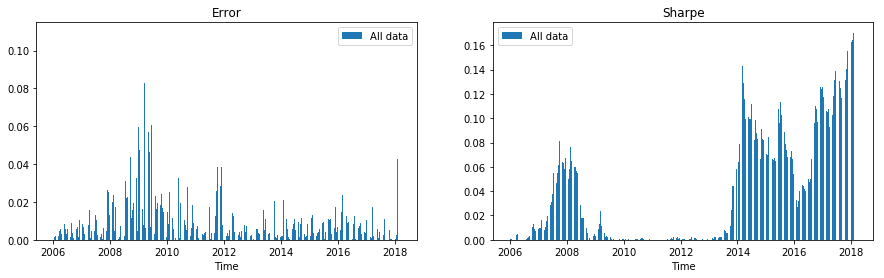

array([<matplotlib.axes._subplots.AxesSubplot object at 0x110415ef0>,
      dtype=object)

In [17]:
plot_perf(df_results, 'All data')

# Input detection

Trains detection algorithms on the input data to the trading strategy and classifies the data as normal or abnormal. The trading strategy is then trained again but only normal data in order to compare the error and the Sharpe ratios of the strategies trained with all the data versus just what the algorithms deem as normal data.

## kNN

In [ ]:
in_knn_norm, in_knn_abnorm = train_detection(ts_data, 'knn')

In [22]:
print_ratio('kNN', in_knn_norm, in_knn_abnorm)

kNN 
Normal: 2894, Abnormal: 1425, Ratio: 0.329937


In [ ]:
knn_results = train_strat(LinearRegression(), in_knn_norm, \
                          int(len(in_knn_norm) * 0.2))

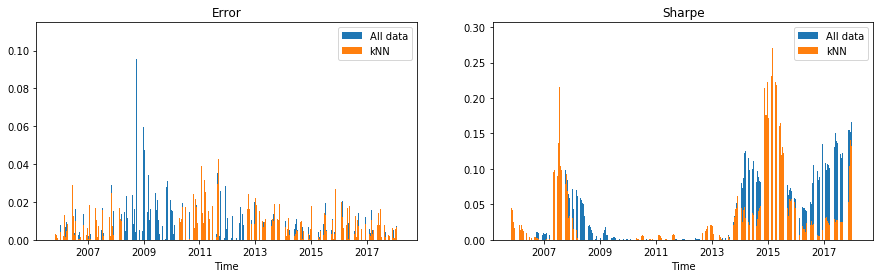

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))        
axs[0].set_title('Error')
axs[0].set_xlabel('Time')
axs[1].set_title('Sharpe')
axs[1].set_xlabel('Time')

error = list(map(rmse, df_results['Obs'].values, df_results['Pred'].values))
axs[0].bar(pd.to_datetime(df_results.index), error, label='All data')
axs[0].legend()

axs[1].bar(pd.to_datetime(df_results.index), df_results['Sharpe'], label='All data')
axs[1].legend()

error = list(map(rmse, knn_results['Obs'].values, knn_results['Pred'].values))
axs[0].bar(pd.to_datetime(knn_results.index), error, label='kNN')
axs[0].legend()

axs[1].bar(pd.to_datetime(knn_results.index), knn_results['Sharpe'], label='kNN')
axs[1].legend()

plt.show()

In [46]:
print_stats('Metrics', 'All data', 'kNN', df_results, knn_results)

Metrics		All data		kNN
RMSE		0.015653	0.012568
Sharpe		-0.379274	-0.557930


## DBSCAN

In [ ]:
in_dbscan_norm, in_dbscan_abnorm = train_detection(ts_data, 'dbscan')

In [67]:
print_ratio('DBSCAN', in_dbscan_norm, in_dbscan_abnorm)

DBSCAN 
Normal: 4019, Abnormal: 300, Ratio: 0.069461


In [ ]:
dbscan_results = train_strat(LinearRegression(), in_dbscan_norm, \
                             int(len(in_dbscan_norm) * 0.2))

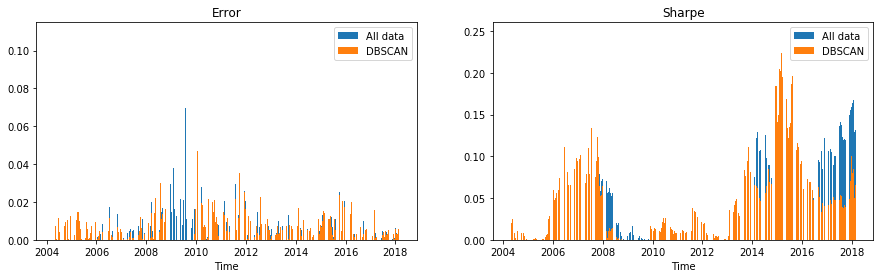

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))        
axs[0].set_title('Error')
axs[0].set_xlabel('Time')
axs[1].set_title('Sharpe')
axs[1].set_xlabel('Time')

error = list(map(rmse, df_results['Obs'].values, df_results['Pred'].values))
axs[0].bar(pd.to_datetime(df_results.index), error, label='All data')
axs[0].legend()

axs[1].bar(pd.to_datetime(df_results.index), df_results['Sharpe'], label='All data')
axs[1].legend()

error = list(map(rmse, dbscan_results['Obs'].values, dbscan_results['Pred'].values))
axs[0].bar(pd.to_datetime(dbscan_results.index), error, label='DBSCAN')
axs[0].legend()

axs[1].bar(pd.to_datetime(dbscan_results.index), dbscan_results['Sharpe'], \
           label='DBSCAN')
axs[1].legend()

plt.show()

In [75]:
print_stats('Metrics', 'All data', 'DBSCAN', df_results, dbscan_results)

Metrics		All data		DBSCAN
RMSE		0.015653	0.012583
Sharpe		-0.379274	-0.167760


## Neural networks

### kNN

In [ ]:
nn_knn_in_norm, nn_knn_in_abnorm = train_nn_detection(\
                                    label_data(in_knn_norm, in_knn_abnorm))

In [71]:
print_ratio('NN-kNN', nn_knn_in_norm, nn_knn_in_abnorm)

NN-kNN 
Normal: 2677, Abnormal: 1642, Ratio: 0.380181


In [ ]:
nn_knn_results = train_strat(LinearRegression(), \
                             nn_knn_in_norm, int(len(nn_knn_in_norm) * 0.2))

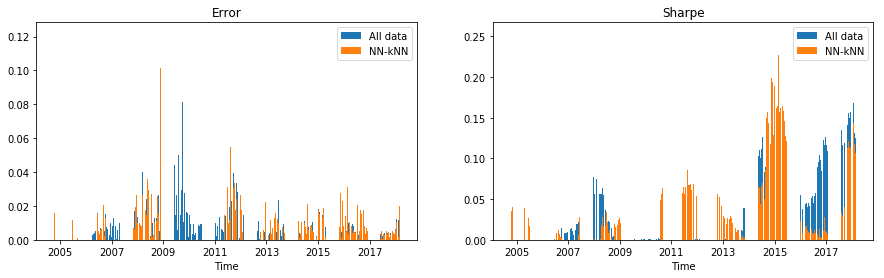

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))        
axs[0].set_title('Error')
axs[0].set_xlabel('Time')
axs[1].set_title('Sharpe')
axs[1].set_xlabel('Time')

error = list(map(rmse, df_results['Obs'].values, df_results['Pred'].values))
axs[0].bar(pd.to_datetime(df_results.index), error, label='All data')
axs[0].legend()

axs[1].bar(pd.to_datetime(df_results.index), df_results['Sharpe'], label='All data')
axs[1].legend()

error = list(map(rmse, nn_knn_results['Obs'].values, nn_knn_results['Pred'].values))
axs[0].bar(pd.to_datetime(nn_knn_results.index), error, label='NN-kNN')
axs[0].legend()

axs[1].bar(pd.to_datetime(nn_knn_results.index), nn_knn_results['Sharpe'],\
           label='NN-kNN')
axs[1].legend()

plt.show()

In [74]:
print_stats('Metrics', 'All data', 'NN-kNN', df_results, nn_knn_results)

Metrics		All data		NN-kNN
RMSE		0.015653	0.018409
Sharpe		-0.379274	-0.258686


### DBSCAN

In [ ]:
nn_dbscan_in_norm, nn_dbscan_in_abnorm = train_nn_detection(\
                label_data(in_dbscan_norm, in_dbscan_abnorm))

In [77]:
print_ratio('NN-DBSCAN', nn_dbscan_in_norm, nn_dbscan_in_abnorm)

NN-DBSCAN 
Normal: 4206, Abnormal: 113, Ratio: 0.026163


In [ ]:
nn_dbscan_results = train_strat(LinearRegression(), \
                                nn_dbscan_in_norm, int(len(nn_dbscan_in_norm) * 0.2))

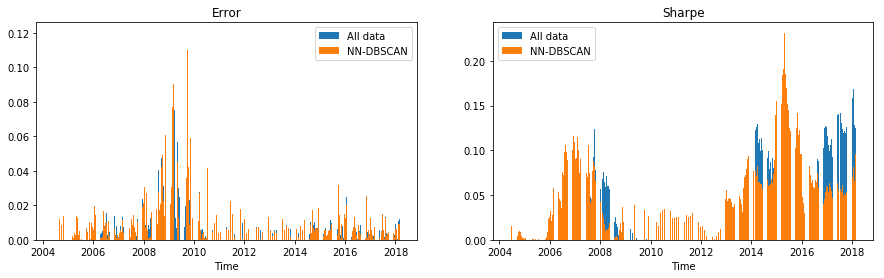

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))        
axs[0].set_title('Error')
axs[0].set_xlabel('Time')
axs[1].set_title('Sharpe')
axs[1].set_xlabel('Time')

error = list(map(rmse, df_results['Obs'].values, df_results['Pred'].values))
axs[0].bar(pd.to_datetime(df_results.index), error, label='All data')
axs[0].legend()

axs[1].bar(pd.to_datetime(df_results.index), df_results['Sharpe'], label='All data')
axs[1].legend()

error = list(map(rmse, nn_dbscan_results['Obs'].values, \
                 nn_dbscan_results['Pred'].values))
axs[0].bar(pd.to_datetime(nn_dbscan_results.index), error, label='NN-DBSCAN')
axs[0].legend()

axs[1].bar(pd.to_datetime(nn_dbscan_results.index), \
           nn_dbscan_results['Sharpe'], label='NN-DBSCAN')
axs[1].legend()

plt.show()

In [80]:
print_stats('Metrics', 'All data', 'NN-DBSCAN', df_results, nn_dbscan_results)

Metrics		All data		NN-DBSCAN
RMSE		0.015653	0.015829
Sharpe		-0.379274	-0.370101


# Output Detection

Trains detection algorithms on the output of the trading strategy algorithm where that is the predicted output, true output, RMSE and Sharpe ratio. Like with the input, they classify the outputs as normal or abnormal in order to predict whether the strategy behaved abnormally in response to the original input. The RMSEs and Sharpe ratios are then compared to show the difference between normal and abnormal data.

## kNN

In [ ]:
out_knn_norm, out_knn_abnorm = train_detection(df_results, 'knn')

In [47]:
print_ratio('kNN', out_knn_norm, out_knn_abnorm)
print()
print_stats('kNN', 'Normal', 'Abnormal', out_knn_norm, out_knn_abnorm)

kNN 
Normal: 1887, Abnormal: 1172, Ratio: 0.383132

kNN		Normal		Abnormal
RMSE		0.008168	0.023067
Sharpe		0.369606	-0.675498


## DBSCAN

In [ ]:
out_dbscan_norm, out_dbscan_abnorm = train_detection(df_results, 'dbscan')

In [49]:
print_ratio('DBSCAN', out_dbscan_norm, out_dbscan_abnorm)
print()
print_stats('DBSCAN', 'Normal', 'Abnormal', out_dbscan_norm, out_dbscan_abnorm)

DBSCAN 
Normal: 2865, Abnormal: 194, Ratio: 0.063419

DBSCAN		Normal		Abnormal
RMSE		0.010895	0.045938
Sharpe		0.225508	-1.872746


## Neural networks

### kNN

In [ ]:
nn_knn_out_norm, nn_knn_out_abnorm = train_nn_detection(\
                                    label_data(out_knn_norm, out_knn_abnorm))

In [106]:
print_ratio('NN-kNN', nn_knn_out_norm, nn_knn_out_abnorm)
print()
print_stats('NN-kNN', 'Normal', 'Abnormal', nn_knn_out_norm, nn_knn_out_abnorm)

NN-kNN 
Normal: 2336, Abnormal: 723, Ratio: 0.236352

NN-kNN		Normal		Abnormal
RMSE		0.017283	0.008461
Sharpe		-0.437646	0.063159


### DBSCAN

In [ ]:
nn_dbscan_out_norm, nn_dbscan_out_abnorm = train_nn_detection(\
                                        label_data(out_dbscan_norm, out_dbscan_abnorm))

In [109]:
print_ratio('NN-DBSCAN', nn_dbscan_out_norm, nn_dbscan_out_abnorm)
print()
print_stats('NN-DBSCAN', 'Normal', 'Abnormal', nn_dbscan_out_norm, \
            nn_dbscan_out_abnorm)

NN-DBSCAN 
Normal: 3059, Abnormal: 0, Ratio: 0.000000

NN-DBSCAN		Normal		Abnormal
RMSE		0.015652916190749253	N/A
Sharpe		-0.3792738036981321	N/A
